In [50]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns


In [33]:
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

In [34]:
# Merge datasets for clustering
customer_data = transactions.merge(customers, on='CustomerID')

In [35]:
# Feature engineering: Aggregate transaction data for each customer
customer_profiles = customer_data.groupby('CustomerID').agg({
    'Region': 'first',
    'Quantity': 'sum',
    'TotalValue': 'sum'
}).reset_index()

In [36]:
# One-hot encode the 'Region' column
customer_profiles = pd.get_dummies(customer_profiles, columns=['Region'], drop_first=True)

In [37]:
# Scale numerical features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_profiles.drop(columns=['CustomerID']))

In [53]:
pip install --upgrade scikit-learn



     ---------------------------------------- 9.3/9.3 MB 2.3 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.0
    Uninstalling scikit-learn-1.3.0:
      Successfully uninstalled scikit-learn-1.3.0


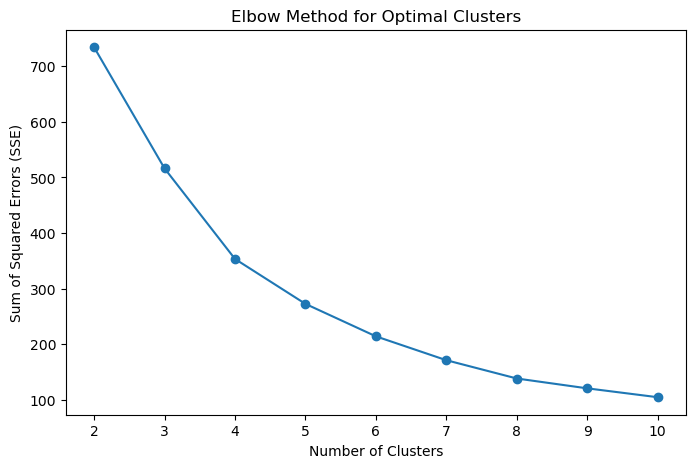

In [57]:
# Find the optimal number of clusters using the elbow method
import warnings
warnings.filterwarnings("ignore", message="KMeans is known to have a memory leak")
sse = []
range_clusters = range(2, 11)
for k in range_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range_clusters, sse, marker='o')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.show()

In [39]:
pip install kneed


Note: you may need to restart the kernel to use updated packages.


In [40]:
from kneed import KneeLocator

# Find the elbow point programmatically
knee_locator = KneeLocator(range_clusters, sse, curve="convex", direction="decreasing")
optimal_clusters = knee_locator.knee
print(f"Optimal Number of Clusters: {optimal_clusters}")


Optimal Number of Clusters: 5


In [60]:
# Choose an optimal number of clusters 
import warnings
warnings.filterwarnings("ignore", message="KMeans is known to have a memory leak")
optimal_clusters = 5
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
kmeans.fit(scaled_features)

KMeans(n_clusters=5, n_init=10, random_state=42)

In [42]:
# Assign cluster labels to customers
customer_profiles['Cluster'] = kmeans.labels_

In [43]:
# Calculate Davies-Bouldin Index
db_index = davies_bouldin_score(scaled_features, kmeans.labels_)
print(f"Davies-Bouldin Index for {optimal_clusters} clusters: {db_index:.2f}")

Davies-Bouldin Index for 5 clusters: 0.79


In [44]:
from sklearn.metrics import silhouette_score
silhouette_avg = silhouette_score(scaled_features, kmeans.labels_)
print(f"Silhouette Score for {optimal_clusters} clusters: {silhouette_avg:.2f}")


Silhouette Score for 5 clusters: 0.46


In [45]:
cluster_sizes = customer_profiles['Cluster'].value_counts()
print(f"Cluster Sizes:\n{cluster_sizes}")

Cluster Sizes:
0    47
4    43
2    41
1    41
3    27
Name: Cluster, dtype: int64


In [46]:
cluster_centroids = pd.DataFrame(kmeans.cluster_centers_, columns=customer_profiles.columns[1:-1])
print(f"Cluster Centroids:\n{cluster_centroids}")


Cluster Centroids:
   Quantity  TotalValue  Region_Europe  Region_North America  \
0 -0.285017   -0.225581       1.726268             -0.548319   
1 -0.237314   -0.315615      -0.579284              1.823756   
2  1.412398    1.388219      -0.410586             -0.259041   
3 -0.743785   -0.713748      -0.579284             -0.548319   
4 -0.341871   -0.327982      -0.579284             -0.548319   

   Region_South America  
0             -0.649175  
1             -0.649175  
2              0.205299  
3             -0.649175  
4              1.540416  


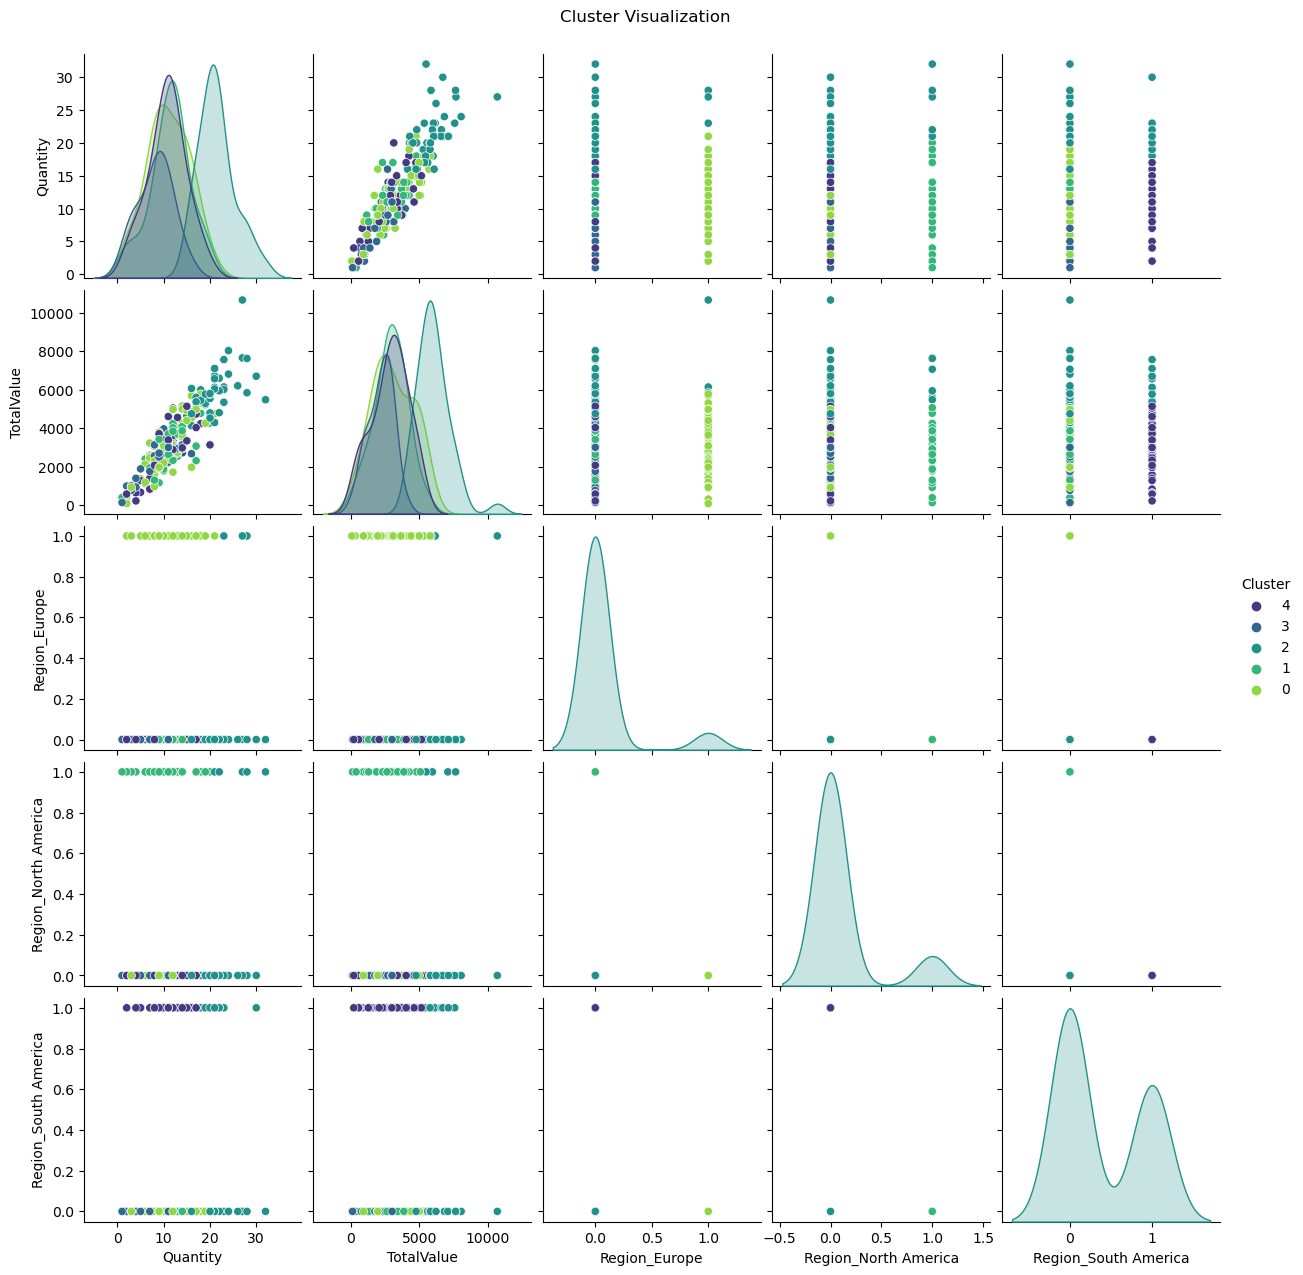

In [47]:
# Visualize the clusters using a pair plot
customer_profiles['Cluster'] = customer_profiles['Cluster'].astype(str)
sns.pairplot(customer_profiles, hue='Cluster', diag_kind='kde', palette='viridis')
plt.suptitle('Cluster Visualization', y=1.02)
plt.show()

In [48]:
# Save the clustering results
#customer_profiles.to_csv('Mamta_Kumari_Clustering.csv', index=False)